In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/dataset_sdn.csv'
df = pd.read_csv(datasheet)

Mounted at /content/drive


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [6]:
#Mengubah kolom kategorial Protokol menjadi string atau object
categorical_cols = ['Protocol']
for col in categorical_cols:
  df[col] = df[col].astype(str)

In [7]:
Features = [
    'dt','dur','dur_nsec','tot_dur','pktrate','Protocol','port_no','tx_kbps',
    'rx_kbps','tot_kbps'
]
df_clean = df[Features]

In [8]:
from sklearn.model_selection import train_test_split

X = df_clean
y = df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [14]:
# Membuat model CatBoos
from catboost import CatBoostClassifier, Pool

modelCat = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=categorical_cols,
    random_seed=42,
    verbose=100,
)

In [16]:
modelCat.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.9051862	test: 0.9069470	best: 0.9069470 (0)	total: 175ms	remaining: 1m 27s
100:	learn: 0.9947093	test: 0.9941306	best: 0.9941306 (100)	total: 11.4s	remaining: 44.9s
200:	learn: 0.9980405	test: 0.9968767	best: 0.9969374 (196)	total: 20.3s	remaining: 30.2s
300:	learn: 0.9988053	test: 0.9976713	best: 0.9976719 (239)	total: 30.2s	remaining: 20s
400:	learn: 0.9988665	test: 0.9976713	best: 0.9976719 (239)	total: 36.4s	remaining: 8.98s
499:	learn: 0.9988512	test: 0.9976716	best: 0.9977327 (454)	total: 43.1s	remaining: 0us

bestTest = 0.9977327042
bestIteration = 454

Shrink model to first 455 iterations.


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred = modelCat.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12712
           1       1.00      1.00      1.00      8157

    accuracy                           1.00     20869
   macro avg       1.00      1.00      1.00     20869
weighted avg       1.00      1.00      1.00     20869



In [21]:
print(f'Akurasi : {acc:.4f}')

Akurasi : 0.9982


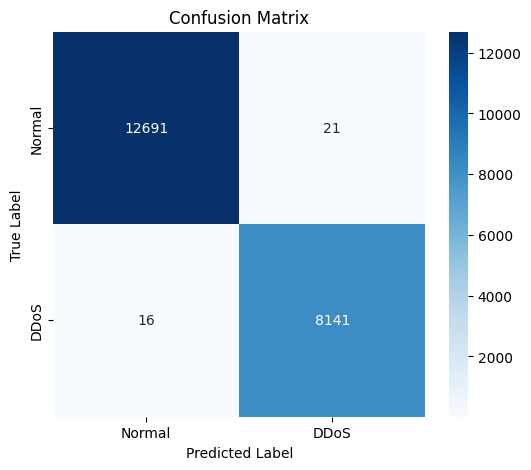

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal','DDoS']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = label,
            yticklabels = label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)
feature_importances = modelCat.get_feature_importance(test_pool)

feat_imp =pd.DataFrame({
    "Feature" : X_test.columns,
    "Importance": feature_importances
}).sort_values(by="Importance",ascending=False)
print(feat_imp)

    Feature  Importance
4   pktrate   46.715863
0        dt   25.409855
5  Protocol   12.991878
1       dur    6.142210
3   tot_dur    4.792728
2  dur_nsec    3.066361
9  tot_kbps    0.517205
8   rx_kbps    0.163884
7   tx_kbps    0.112304
6   port_no    0.087712


/tmp/ipython-input-2673273320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y='Feature', palette='viridis')


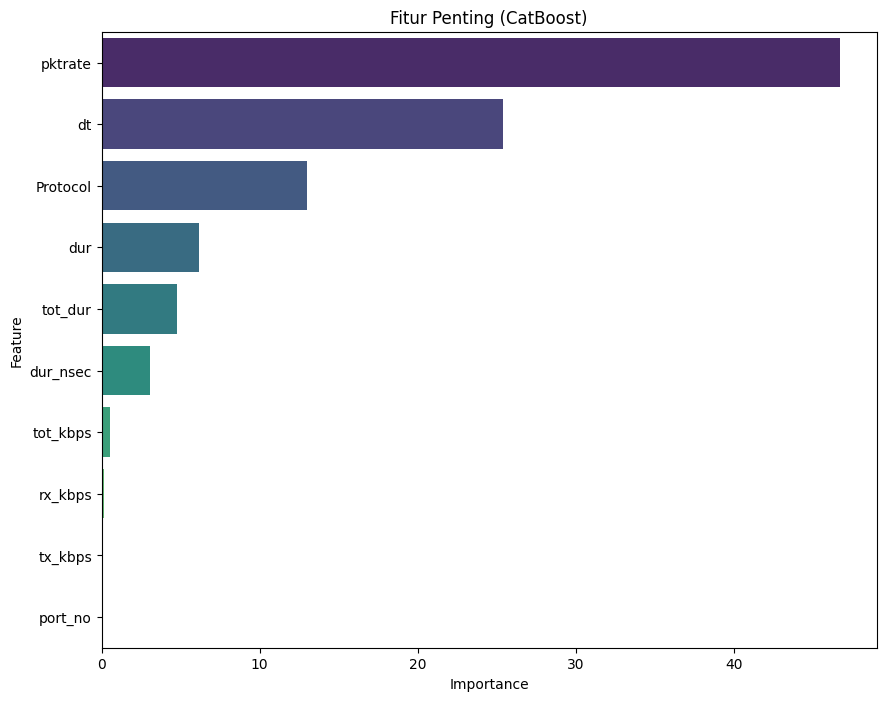

In [27]:
plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp, x="Importance", y='Feature', palette='viridis')
plt.title('Fitur Penting (CatBoost)')
plt.show()

In [28]:
from google.colab import files
modelCat.save_model('catboost_detection_DDoS.cbm')
files.download('catboost_detection_DDoS.cbm')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>